In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import copy
from collections import Iterable
import json

from keras import Model, Input, Sequential, regularizers, losses, optimizers, regularizers, initializers
from keras.layers import Activation, Dense, LSTM, Embedding, Dropout, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso
from sklearn.feature_selection import f_regression, mutual_info_regression
from scipy.optimize import golden, minimize, differential_evolution
from tsfresh.feature_selection.relevance import calculate_relevance_table
import boruta

%matplotlib inline

Using TensorFlow backend.


In [2]:
plt.style.use(plt.style.library['dark_background'])
plt.rcParams['grid.color'] = '#333333'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
class SelectModel():
    def __init__(self, model, threshold=1e-5, max_features=None):
        self.model = model
        self.threshold = threshold
        self.max_features = max_features
    
    def fit(self, X, y):
        self.model.fit(X,y)
        if hasattr(self.model,'coef_'):
            scores = abs(self.model.coef_)
        else:
            scores = self.model.feature_importances_
        
        f = scores
        f = f/f.sum()
        self.ranks_ = pd.Series(f, index=X.columns, name='ranks')
        
        ranks_sort = self.ranks_.sort_values(ascending=False) 
        
        scores = pd.Series(scores, X.columns)
        selected_features_ = scores[scores>1e-5].index
        
        if self.max_features is None:
            self.max_features = X.shape[1]
            
        if len(selected_features_) > self.max_features:
            selected_features_ = ranks_sort.iloc[:self.max_features].index
        
        self.selected_features_ = np.array(selected_features_)
            
        return self

In [4]:
class SelectTsfresh():
    def __init__(self, fdr_level=0.05):
        self.fdr_level = fdr_level
    
    def fit(self, X, y):
        if y.ndim>1:
            print('WARNING: Tsfresh don\'t support multitarget. "y" should be a pd.Series')
            y = y.iloc[:,0]
        if not isinstance(y, pd.Series):
            y = pd.Series(y, index=X.index)
        
        relevance = calculate_relevance_table(X, y, fdr_level=self.fdr_level)
        relevance = relevance.reindex(X.columns)
        
        f = relevance['p_value'].dropna()
        f = 1-f
        f = f/f.sum()
        relevance['ranks'] = f
        relevance['ranks'].fillna(0, inplace=True)
        self.ranks_ = relevance['ranks']
        
        self.selected_features_ = relevance[relevance['relevant']==True]['feature'].values
        
        return self

In [5]:
class SelectFunction():
    def __init__(self, function, volume_info=0.97, max_features=None):
        self.function = function
        self.volume_info = volume_info
        self.max_features = max_features
    
    def fit(self, X, y):
        scores = self.function(X,y)
        if isinstance(scores, tuple):
            scores = scores[0]
        
        f = np.nan_to_num(scores)
        f = f/f.sum()
        self.ranks_ = pd.Series(f, index=X.columns, name='ranks')
        
        ranks_sort = self.ranks_.sort_values(ascending=False) 

        for i in ranks_sort.index:
            summ = ranks_sort[:i].sum()
            if summ > self.volume_info:
                break
        selected_features_ = ranks_sort[:i].index
        
        if self.max_features is None:
            self.max_features = X.shape[1]
            
        if len(selected_features_) > self.max_features:
            selected_features_ = ranks_sort.iloc[:self.max_features].index
        
        self.selected_features_ = np.array(selected_features_)
            
        return self

In [6]:
class SelectBoruta():
    def __init__(self, boruta, only_confirmed=True, prefit=False):
        self.prefit = prefit
        self.core = boruta
        self.only_confirmed = only_confirmed
    
    def fit(self, X, y):
        if not self.prefit:
            self.core.fit(np.array(X), np.array(y))
        
        f = self.core.ranking_
        f = f.sum()/f
        f = f/f.sum()
        
        self.ranks_ = pd.Series(f, index=X.columns, name='ranks')
        
        if self.only_confirmed:
            z = zip(X.columns, self.core.support_, np.zeros(X.shape[1]))
        else:
            z = zip(X.columns, self.core.support_, self.core.support_weak_)
            
        selected_features_ = []
        for i in z:
            if i[1] or i[2]:
                selected_features_.append(i[0])
        
        self.selected_features_ = np.array(selected_features_)
            
        return self

In [7]:
def mass_fit(X, y, models, metrics=mse, scalerY=None, seed=None, verbose=True):
    if not isinstance(models, Iterable):
        models = (models,)
    if not isinstance(metrics, Iterable):
        metrics = (metrics,)
    
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.25, shuffle=False)
    
    if verbose:
        print(f'train on {len(trainY)}, test on {len(testY)} rows x {len(trainX.columns)} columns')
    
    total = []

    for model in models:
        if seed is not None:
            np.random.seed(seed)
        
        cls = model.__class__
        
        model.fit(trainX, trainY)
        preds = model.predict(testX)
        
        if scalerY is not None:
            preds = scalerY.inverse_transform(np.array(preds).reshape(-1,1))
            _testY = scalerY.inverse_transform(np.array(testY).reshape(-1,1))
        else:
            _testY = testY
        
        result = {}
        for metric in metrics:
            result[metric.__name__] = metric(_testY, preds)
            
        if verbose:
            print(f'{cls.__name__:21} {result}')

        total.append({'result':result, 'core':model})
        
    np.random.seed()
    return total

In [8]:
class SelectEnsemble:
    def __init__(self, X, y, scalerY=None, metric=mse):
        self.X = X
        self.y = y
        self.scalerY = scalerY
        self.metric = metric
        self.raw_score = None
    
    def _estimator_score(self, feats=None, agg_func=np.min):
        if feats is None:
            feats = self.X.columns
        mass_fit_res = mass_fit(self.X[feats], self.y, self._xgb_gen(), scalerY=self.scalerY, metrics=self.metric)
        return agg_func(np.array([a['result'][self.metric.__name__] for a in mass_fit_res]))
        
    @staticmethod
    def _xgb_gen():
#         for i in np.linspace(0.1, 0.5, 5):
#             yield XGBRegressor(6, i,  n_estimators=20)
        for i in [7]:
            yield XGBRegressor(i, 0.1,  n_estimators=30)
#         yield RandomForestRegressor(50)

    def _calc_raw_score(self):
        print('Raw data...')
        raw_score = self._estimator_score()
        print('Raw score:', raw_score, '\n')
        self.raw_score = raw_score
        
    def select_features(self, a):
        ranks_sort = self.FI.sort_values(ascending=False)
        ranks_sort = ranks_sort/ranks_sort.sum()

        for i in ranks_sort.index:
            summ = ranks_sort[:i].sum()
            if summ > a:
                break
        selected_features = ranks_sort[:i].index

        res = self._estimator_score(selected_features)
        
        self.selected_features = selected_features
        
        print(a,':',len(selected_features),res)
        return selected_features

    def fit(self, methods, seed=None):
        if self.raw_score is None:
            self._calc_raw_score()
        
        results = []
        FI = []

        if not isinstance(methods, Iterable):
            methods = (methods,)

        for method in methods:
            print(method.__class__.__name__+'...')

            if seed is not None:
                np.random.seed(seed)

            method.fit(self.X, self.y)

            selected_features = method.selected_features_

            test_score = self._estimator_score(selected_features)

            ranks = method.ranks_
            quality = self.raw_score/test_score

            FI.append(ranks * quality) #  quality**alpha ?

            results.append([method, selected_features, test_score, quality, ranks])

            print('quality:', quality)
            print('features selected:', len(selected_features), '\n')

        FI = np.array(FI).sum(0)
        FI = pd.Series(FI, index=X.columns)

        results = pd.DataFrame(results, columns=['core', 'selected_features', 'test_score', 'quality', 'ranks'])
        
        self.FI = FI
        self.results = results
        
        np.random.seed()
        
        return results, FI

In [9]:
class LightNN:
    def __init__(self, epochs, batch_size, neurons=200, lr=0.001, loss='mse', activation='tanh', validation_data=None, verbose=1):
        self.epochs = epochs
        self.batch_size = batch_size
        self.neurons = neurons
        self.lr = lr
        self.loss = loss
        self.activation = activation

        self.full_hist_loss = []
        self.full_hist_val = []

        self._verbose = verbose
        self._validation_data = validation_data


    def _build(self, X, y):
        n_feats = X.shape[1]
        size = X.shape[0]

        inputs = Input((n_feats,))
        x = Dense(self.neurons, activation=self.activation)(inputs)
        x = Dropout(0.5)(x)
        x = Dense(np.array(y).reshape((size, -1)).shape[1])(x)
        neural = Model(inputs=inputs, outputs=x)

        neural.compile(optimizer=optimizers.Adam(lr=self.lr, decay=0.), loss=self.loss, metrics=['mse'])

        self.model = neural


    def fit(self, X=None, y=None):
        self._build(X, y)

        self.model.fit(X, y, shuffle=False, verbose=self._verbose,
                       epochs=self.epochs, batch_size=self.batch_size, validation_data=self._validation_data,
                       callbacks=[
                           ModelCheckpoint('tmp_model.hdf5', monitor='val_mean_squared_error', save_best_only=True, save_weights_only=True)
                       ]
                      )
                               

        self.full_hist_loss += self.model.history.history['mean_squared_error']
        self.full_hist_val += self.model.history.history['val_mean_squared_error']
        
        if min(self.model.history.history['val_mean_squared_error']) != self.model.history.history['val_mean_squared_error'][-1]:
            if (self._verbose>0):
                plt.plot(self.full_hist_loss)
                plt.plot(self.full_hist_val)
                plt.show()
                print('loading...')
            self.model.load_weights('tmp_model.hdf5')

        return self


    def predict(self, X):
        preds = self.model.predict(X, len(X))
        return preds

In [11]:
def train_test_split(x, y, test_size=0.25, shuffle=False):
    """x_train, x_test, y_train, y_test"""
    t = int(1/(test_size))
    
    y = pd.DataFrame(y, index=x.index)
    
    test_index = x.index[t-1::t]
    
    x_train = x.drop(test_index)
    y_train = y.drop(test_index)
    x_test = x.loc[test_index]
    y_test = y.loc[test_index]
    
    y_test = np.array(y_test).ravel()
    y_train = np.array(y_train).ravel()
    return x_train, x_test, y_train, y_test

## Start

In [10]:
dataset = pd.read_hdf('/data_1/fosagro/df_interpolated_11aug.h5', 'table')
dataset.drop('date', axis=1, inplace=True)

shift = 120
name = '121-1 P2O5 в хвостах 3 оч'
target = name+str(-shift)

In [11]:
# add shift
dataset[target] = dataset[name].shift(-shift)

dataset.dropna(inplace=True)

In [16]:
dataset = dataset.iloc[:50000]

In [12]:
scalerX = None
scalerY = None

X = dataset.drop(target, axis=1)
Y = dataset[[target]]

# Standard Scaler

# scalerX = StandardScaler()
# X = pd.DataFrame(scalerX.fit_transform(X), X.index, columns=X.columns)

# scalerY = StandardScaler()
# Y = scalerY.fit_transform(Y).ravel()

# MinMax Scaler

# scalerX = MinMaxScaler()
# X = pd.DataFrame(scalerX.fit_transform(X), X.index, columns=X.columns)

# scalerY = MinMaxScaler()
# Y = scalerY.fit_transform(Y).ravel()

Y = np.array(Y).ravel()

## dummy

In [13]:
print(f'rmse: {rmse(dataset[name], dataset[target])}\nr2: {r2(dataset[name], dataset[target])}')

rmse: 0.4802908279416273
r2: 0.07234652465173774


In [29]:
mass_fit(X,Y, LightNN(15,100000, activation='tanh', lr=0.001, validation_data=train_test_split(X, Y)[1::2]), scalerY=scalerY, metrics=[mse,rmse,r2])

train on 251098, test on 251098 rows x 162 columns
Train on 251098 samples, validate on 251098 samples
Epoch 1/15
251098/251098 [==============================] - 2s 7us/step - loss: 2.0151 - mean_squared_error: 2.0151 - val_loss: 1.1936 - val_mean_squared_error: 1.1936
Epoch 2/15
251098/251098 [==============================] - 2s 6us/step - loss: 1.8361 - mean_squared_error: 1.8361 - val_loss: 1.0175 - val_mean_squared_error: 1.0175
Epoch 3/15


KeyboardInterrupt: 

In [125]:
mass_fit(X, Y, XGBRegressor(7,0.1,30),scalerY=scalerY, metrics=[mse,rmse,r2]);

train on 376647, test on 125549 rows x 162 columns
XGBRegressor          {'mean_squared_error': 0.06269858775989816, 'rmse': 0.2503968605232465, 'r2_score': 0.7483316863564743}


In [126]:
0.06269858775989816

0.06269858775989816

## Selection

In [170]:
ens = SelectEnsemble(X, Y, scalerY=scalerY, metric=mse)
ens.raw_score = 0.06269858775989816 #  mse

In [171]:
ens.FI = FI
ens.results = results

In [132]:
ens.fit([
    SelectModel(Lasso(0.004)), 
    SelectFunction(f_regression, 0.97),
#     SelectFunction(mutual_info_regression, 0.97),
    SelectTsfresh()
]);

SelectModel...
train on 376647, test on 125549 rows x 95 columns
XGBRegressor          {'mean_squared_error': 0.08066628023640245}
XGBRegressor          {'mean_squared_error': 0.06555904977569553}
quality: 0.9563681593070036
features selected: 95 

SelectFunction...
train on 376647, test on 125549 rows x 101 columns
XGBRegressor          {'mean_squared_error': 0.08088296226223325}
XGBRegressor          {'mean_squared_error': 0.06647531146056988}
quality: 0.9431860698702871
features selected: 101 

SelectTsfresh...
train on 376647, test on 125549 rows x 159 columns
XGBRegressor          {'mean_squared_error': 0.07709904514032559}
XGBRegressor          {'mean_squared_error': 0.06304174956026445}
quality: 0.9945565945939008
features selected: 159 



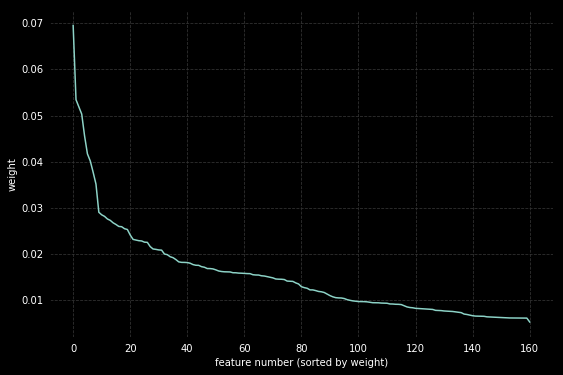

In [178]:
plt.plot(ens.FI.sort_values(ascending=False).values[1:])
plt.ylabel('weight')
plt.xlabel('feature number (sorted by weight)');

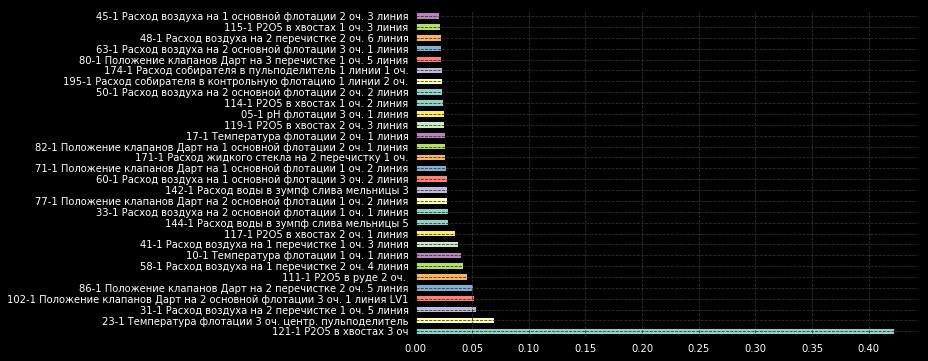

In [173]:
ens.FI.sort_values(ascending=False)[:30].plot.barh()

In [140]:
FI = ens.FI
results = ens.results

In [177]:
selected_features = ens.select_features(0.97)

train on 376647, test on 125549 rows x 148 columns
XGBRegressor          {'mean_squared_error': 0.07821418286665133}
XGBRegressor          {'mean_squared_error': 0.06394966919704803}
0.97 : 148 0.06394966919704803


# Predict

### RAW

In [365]:
validation_data = train_test_split(X, Y)[1::2]

mass_fit(x, y, scalerY=scalerY, models=
                   [
#                        XGBRegressor(7, 0.1, 30),
                       LightNN(350, 1000, activation='sigmoid', validation_data=validation_data, verbose=0),
                       RandomForestRegressor(100)
                   ]);

train on 201, test on 201 rows x 4310 columns
XGBRegressor          2.367073
LightNN               4.020452


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor 2.350580


### Selected

In [368]:
validation_data = train_test_split(X[selected_features], Y)[1::2]

mass_fit(X[selected_features], Y, scalerY=scalerY, models=
                   [
#                        XGBRegressor(7, 0.1, 30),
                       LightNN(350, 1000, activation='tanh', validation_data=validation_data, verbose=0),
                       RandomForestRegressor(100)
                   ]);

train on 201, test on 201 rows x 60 columns
XGBRegressor          2.072067
LightNN               4.030576


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor 2.143295


# NN test

## AD

In [50]:
targ = 'AD'
feats = selected_features_AD

X_train, X_test, y_train, y_test = train_test_split(X[feats], Y[targ], shuffle=False)

n_feats = len(feats)

In [51]:
inputs = Input((n_feats,))
x = Dense(200, activation='tanh')(inputs)
x = Dropout(0.5)(x)
x = Dense(1)(x)
neural = Model(inputs=inputs, outputs=x)

neural.compile(optimizer=optimizers.Adam(lr=0.0006, decay=0.), loss='mse', metrics=['mse'])

neural.fit(X_train, y_train, epochs=350, batch_size=1000, shuffle=False)

Epoch 1/350
201/201 [==============================] - 1s 3ms/step - loss: 63.0545 - mean_squared_error: 63.0545
Epoch 2/350
201/201 [==============================] - 0s 108us/step - loss: 13.3720 - mean_squared_error: 13.3720
Epoch 3/350
201/201 [==============================] - 0s 107us/step - loss: 8.5906 - mean_squared_error: 8.5906
Epoch 4/350
201/201 [==============================] - 0s 111us/step - loss: 7.0869 - mean_squared_error: 7.0869
Epoch 5/350
201/201 [==============================] - 0s 115us/step - loss: 8.3466 - mean_squared_error: 8.3466
Epoch 6/350
201/201 [==============================] - 0s 133us/step - loss: 6.6165 - mean_squared_error: 6.6165
Epoch 7/350
201/201 [==============================] - 0s 137us/step - loss: 6.3639 - mean_squared_error: 6.3639
Epoch 8/350
201/201 [==============================] - 0s 109us/step - loss: 6.4553 - mean_squared_error: 6.4553
Epoch 9/350
201/201 [==============================] - 0s 136us/step - loss: 6.0079 - mean_squ

Epoch 73/350
201/201 [==============================] - 0s 115us/step - loss: 5.6771 - mean_squared_error: 5.6771
Epoch 74/350
201/201 [==============================] - 0s 113us/step - loss: 6.1955 - mean_squared_error: 6.1955
Epoch 75/350
201/201 [==============================] - 0s 111us/step - loss: 6.6789 - mean_squared_error: 6.6789
Epoch 76/350
201/201 [==============================] - 0s 101us/step - loss: 7.0321 - mean_squared_error: 7.0321
Epoch 77/350
201/201 [==============================] - 0s 109us/step - loss: 6.0525 - mean_squared_error: 6.0525
Epoch 78/350
201/201 [==============================] - 0s 123us/step - loss: 6.7598 - mean_squared_error: 6.7598
Epoch 79/350
201/201 [==============================] - 0s 114us/step - loss: 5.7985 - mean_squared_error: 5.7985
Epoch 80/350
201/201 [==============================] - 0s 120us/step - loss: 6.1368 - mean_squared_error: 6.1368
Epoch 81/350
201/201 [==============================] - 0s 115us/step - loss: 6.4936 - m

Epoch 145/350
201/201 [==============================] - 0s 106us/step - loss: 6.0943 - mean_squared_error: 6.0943
Epoch 146/350
201/201 [==============================] - 0s 118us/step - loss: 6.2841 - mean_squared_error: 6.2841
Epoch 147/350
201/201 [==============================] - 0s 104us/step - loss: 5.9614 - mean_squared_error: 5.9614
Epoch 148/350
201/201 [==============================] - 0s 107us/step - loss: 6.3988 - mean_squared_error: 6.3988
Epoch 149/350
201/201 [==============================] - 0s 109us/step - loss: 6.3462 - mean_squared_error: 6.3462
Epoch 150/350
201/201 [==============================] - 0s 111us/step - loss: 5.8060 - mean_squared_error: 5.8060
Epoch 151/350
201/201 [==============================] - 0s 100us/step - loss: 5.6834 - mean_squared_error: 5.6834
Epoch 152/350
201/201 [==============================] - 0s 93us/step - loss: 5.9938 - mean_squared_error: 5.9938
Epoch 153/350
201/201 [==============================] - 0s 98us/step - loss: 6.1

Epoch 217/350
201/201 [==============================] - 0s 109us/step - loss: 5.6748 - mean_squared_error: 5.6748
Epoch 218/350
201/201 [==============================] - 0s 114us/step - loss: 6.4228 - mean_squared_error: 6.4228
Epoch 219/350
201/201 [==============================] - 0s 128us/step - loss: 5.9091 - mean_squared_error: 5.9091
Epoch 220/350
201/201 [==============================] - 0s 105us/step - loss: 5.6805 - mean_squared_error: 5.6805
Epoch 221/350
201/201 [==============================] - 0s 110us/step - loss: 6.3361 - mean_squared_error: 6.3361
Epoch 222/350
201/201 [==============================] - 0s 113us/step - loss: 5.8622 - mean_squared_error: 5.8622
Epoch 223/350
201/201 [==============================] - 0s 106us/step - loss: 6.1664 - mean_squared_error: 6.1664
Epoch 224/350
201/201 [==============================] - 0s 126us/step - loss: 6.3733 - mean_squared_error: 6.3733
Epoch 225/350
201/201 [==============================] - 0s 136us/step - loss: 6

Epoch 289/350
201/201 [==============================] - 0s 113us/step - loss: 5.6442 - mean_squared_error: 5.6442
Epoch 290/350
201/201 [==============================] - 0s 115us/step - loss: 5.9949 - mean_squared_error: 5.9949
Epoch 291/350
201/201 [==============================] - 0s 112us/step - loss: 6.5046 - mean_squared_error: 6.5046
Epoch 292/350
201/201 [==============================] - 0s 105us/step - loss: 5.8892 - mean_squared_error: 5.8892
Epoch 293/350
201/201 [==============================] - 0s 108us/step - loss: 5.6946 - mean_squared_error: 5.6946
Epoch 294/350
201/201 [==============================] - 0s 104us/step - loss: 4.8651 - mean_squared_error: 4.8651
Epoch 295/350
201/201 [==============================] - 0s 121us/step - loss: 5.5569 - mean_squared_error: 5.5569
Epoch 296/350
201/201 [==============================] - 0s 138us/step - loss: 5.2509 - mean_squared_error: 5.2509
Epoch 297/350
201/201 [==============================] - 0s 124us/step - loss: 4

In [52]:
p = neural.predict(X_test, len(X))*scale_mean[targ]['scale']+scale_mean[targ]['mean']
_test = y_test*scale_mean[targ]['scale']+scale_mean[targ]['mean']

result_AD = mean_squared_error(p,_test)
result_AD

3.910935452184633

## WT

In [171]:
targ = 'WT'
feats = selected_features_WT

X_train, X_test, y_train, y_test = train_test_split(X[feats], Y[targ], shuffle=False)

n_feats = len(feats)

In [172]:
inputs = Input((n_feats,))
x = Dense(200, activation='tanh')(inputs)
x = Dropout(0.5)(x)
x = Dense(1)(x)
neural = Model(inputs=inputs, outputs=x)

neural.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.), loss='mse', metrics=['mse'])

neural.fit(X_train, y_train, epochs=250, batch_size=1000, shuffle=False)

Epoch 1/250
301/301 [==============================] - 2s 6ms/step - loss: 116.4929 - mean_squared_error: 116.4929
Epoch 2/250
301/301 [==============================] - 0s 19us/step - loss: 80.8007 - mean_squared_error: 80.8007
Epoch 3/250
301/301 [==============================] - 0s 22us/step - loss: 55.6509 - mean_squared_error: 55.6509
Epoch 4/250
301/301 [==============================] - 0s 18us/step - loss: 42.1868 - mean_squared_error: 42.1868
Epoch 5/250
301/301 [==============================] - 0s 23us/step - loss: 33.1816 - mean_squared_error: 33.1816
Epoch 6/250
301/301 [==============================] - 0s 21us/step - loss: 27.5976 - mean_squared_error: 27.5976
Epoch 7/250
301/301 [==============================] - 0s 24us/step - loss: 24.8995 - mean_squared_error: 24.8995
Epoch 8/250
301/301 [==============================] - 0s 21us/step - loss: 23.8910 - mean_squared_error: 23.8910
Epoch 9/250
301/301 [==============================] - 0s 23us/step - loss: 20.9660 - m

Epoch 74/250
301/301 [==============================] - 0s 17us/step - loss: 4.9562 - mean_squared_error: 4.9562
Epoch 75/250
301/301 [==============================] - 0s 21us/step - loss: 5.0796 - mean_squared_error: 5.0796
Epoch 76/250
301/301 [==============================] - 0s 19us/step - loss: 5.1657 - mean_squared_error: 5.1657
Epoch 77/250
301/301 [==============================] - 0s 23us/step - loss: 5.1345 - mean_squared_error: 5.1345
Epoch 78/250
301/301 [==============================] - 0s 19us/step - loss: 5.3822 - mean_squared_error: 5.3822
Epoch 79/250
301/301 [==============================] - 0s 17us/step - loss: 5.1846 - mean_squared_error: 5.1846
Epoch 80/250
301/301 [==============================] - 0s 19us/step - loss: 4.6594 - mean_squared_error: 4.6594
Epoch 81/250
301/301 [==============================] - 0s 22us/step - loss: 4.6275 - mean_squared_error: 4.6275
Epoch 82/250
301/301 [==============================] - 0s 22us/step - loss: 5.8318 - mean_squar

301/301 [==============================] - 0s 25us/step - loss: 5.3098 - mean_squared_error: 5.3098
Epoch 147/250
301/301 [==============================] - 0s 27us/step - loss: 5.0016 - mean_squared_error: 5.0016
Epoch 148/250
301/301 [==============================] - 0s 20us/step - loss: 4.3851 - mean_squared_error: 4.3851
Epoch 149/250
301/301 [==============================] - 0s 27us/step - loss: 5.1918 - mean_squared_error: 5.1918
Epoch 150/250
301/301 [==============================] - 0s 19us/step - loss: 4.2027 - mean_squared_error: 4.2027
Epoch 151/250
301/301 [==============================] - 0s 22us/step - loss: 5.5856 - mean_squared_error: 5.5856
Epoch 152/250
301/301 [==============================] - 0s 20us/step - loss: 4.5520 - mean_squared_error: 4.5520
Epoch 153/250
301/301 [==============================] - 0s 24us/step - loss: 5.1873 - mean_squared_error: 5.1873
Epoch 154/250
301/301 [==============================] - 0s 20us/step - loss: 4.7842 - mean_squared_er

Epoch 218/250
301/301 [==============================] - 0s 25us/step - loss: 4.6822 - mean_squared_error: 4.6822
Epoch 219/250
301/301 [==============================] - 0s 18us/step - loss: 4.9429 - mean_squared_error: 4.9429
Epoch 220/250
301/301 [==============================] - 0s 23us/step - loss: 5.0054 - mean_squared_error: 5.0054
Epoch 221/250
301/301 [==============================] - 0s 22us/step - loss: 5.0399 - mean_squared_error: 5.0399
Epoch 222/250
301/301 [==============================] - 0s 24us/step - loss: 5.5863 - mean_squared_error: 5.5863
Epoch 223/250
301/301 [==============================] - 0s 26us/step - loss: 5.1722 - mean_squared_error: 5.1722
Epoch 224/250
301/301 [==============================] - 0s 26us/step - loss: 5.3322 - mean_squared_error: 5.3322
Epoch 225/250
301/301 [==============================] - 0s 21us/step - loss: 4.9763 - mean_squared_error: 4.9763
Epoch 226/250
301/301 [==============================] - 0s 28us/step - loss: 4.3324 - m

In [173]:
p = neural.predict(X_test, len(X))*scale_mean[targ]['scale']+scale_mean[targ]['mean']
_test = y_test*scale_mean[targ]['scale']+scale_mean[targ]['mean']

result_WT = mean_squared_error(p,_test)
result_WT

3.55012574663479

## MultiTarget

In [174]:
selected_features_multi = list(selected_features_AD) + list(selected_features_WT)

In [175]:
targ = ['AD','WT']
feats = selected_features_multi

X_train, X_test, y_train, y_test = train_test_split(X[feats], Y[targ], shuffle=False)

n_feats = len(feats)

In [176]:
inputs = Input((n_feats,))
x = Dense(200, activation='tanh')(inputs)
x = Dropout(0.5)(x)
x = Dense(2)(x)
neural = Model(inputs=inputs, outputs=x)

neural.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.), loss='mse', metrics=['mse'])

neural.fit(X_train, y_train, epochs=450, batch_size=1000, shuffle=False)

Epoch 1/450
301/301 [==============================] - 2s 6ms/step - loss: 99.9708 - mean_squared_error: 99.9708
Epoch 2/450
301/301 [==============================] - 0s 29us/step - loss: 53.4918 - mean_squared_error: 53.4918
Epoch 3/450
301/301 [==============================] - 0s 30us/step - loss: 39.8632 - mean_squared_error: 39.8632
Epoch 4/450
301/301 [==============================] - 0s 30us/step - loss: 34.1488 - mean_squared_error: 34.1488
Epoch 5/450
301/301 [==============================] - 0s 26us/step - loss: 29.5237 - mean_squared_error: 29.5237
Epoch 6/450
301/301 [==============================] - 0s 34us/step - loss: 28.5566 - mean_squared_error: 28.5566
Epoch 7/450
301/301 [==============================] - 0s 30us/step - loss: 25.2301 - mean_squared_error: 25.2301
Epoch 8/450
301/301 [==============================] - 0s 27us/step - loss: 23.7388 - mean_squared_error: 23.7388
Epoch 9/450
301/301 [==============================] - 0s 29us/step - loss: 22.5738 - mea

Epoch 74/450
301/301 [==============================] - 0s 29us/step - loss: 5.8561 - mean_squared_error: 5.8561
Epoch 75/450
301/301 [==============================] - 0s 30us/step - loss: 5.5832 - mean_squared_error: 5.5832
Epoch 76/450
301/301 [==============================] - 0s 27us/step - loss: 5.7692 - mean_squared_error: 5.7692
Epoch 77/450
301/301 [==============================] - 0s 30us/step - loss: 5.8547 - mean_squared_error: 5.8547
Epoch 78/450
301/301 [==============================] - 0s 30us/step - loss: 6.1903 - mean_squared_error: 6.1903
Epoch 79/450
301/301 [==============================] - 0s 25us/step - loss: 5.8927 - mean_squared_error: 5.8927
Epoch 80/450
301/301 [==============================] - 0s 24us/step - loss: 6.0277 - mean_squared_error: 6.0277
Epoch 81/450
301/301 [==============================] - 0s 24us/step - loss: 6.2317 - mean_squared_error: 6.2317
Epoch 82/450
301/301 [==============================] - 0s 27us/step - loss: 6.0108 - mean_squar

301/301 [==============================] - 0s 27us/step - loss: 5.6687 - mean_squared_error: 5.6687
Epoch 147/450
301/301 [==============================] - 0s 25us/step - loss: 6.4250 - mean_squared_error: 6.4250
Epoch 148/450
301/301 [==============================] - 0s 39us/step - loss: 5.8432 - mean_squared_error: 5.8432
Epoch 149/450
301/301 [==============================] - 0s 25us/step - loss: 5.5223 - mean_squared_error: 5.5223
Epoch 150/450
301/301 [==============================] - 0s 31us/step - loss: 6.1824 - mean_squared_error: 6.1824
Epoch 151/450
301/301 [==============================] - 0s 34us/step - loss: 6.1621 - mean_squared_error: 6.1621
Epoch 152/450
301/301 [==============================] - 0s 26us/step - loss: 6.2125 - mean_squared_error: 6.2125
Epoch 153/450
301/301 [==============================] - 0s 30us/step - loss: 5.9201 - mean_squared_error: 5.9201
Epoch 154/450
301/301 [==============================] - 0s 33us/step - loss: 5.6250 - mean_squared_er

Epoch 218/450
301/301 [==============================] - 0s 28us/step - loss: 5.6575 - mean_squared_error: 5.6575
Epoch 219/450
301/301 [==============================] - 0s 30us/step - loss: 5.2321 - mean_squared_error: 5.2321
Epoch 220/450
301/301 [==============================] - 0s 32us/step - loss: 5.7536 - mean_squared_error: 5.7536
Epoch 221/450
301/301 [==============================] - 0s 27us/step - loss: 5.6024 - mean_squared_error: 5.6024
Epoch 222/450
301/301 [==============================] - 0s 44us/step - loss: 6.1860 - mean_squared_error: 6.1860
Epoch 223/450
301/301 [==============================] - 0s 27us/step - loss: 6.2770 - mean_squared_error: 6.2770
Epoch 224/450
301/301 [==============================] - 0s 25us/step - loss: 5.9374 - mean_squared_error: 5.9374
Epoch 225/450
301/301 [==============================] - 0s 27us/step - loss: 5.4930 - mean_squared_error: 5.4930
Epoch 226/450
301/301 [==============================] - 0s 26us/step - loss: 6.2316 - m

Epoch 290/450
301/301 [==============================] - 0s 26us/step - loss: 5.3257 - mean_squared_error: 5.3257
Epoch 291/450
301/301 [==============================] - 0s 26us/step - loss: 5.9315 - mean_squared_error: 5.9315
Epoch 292/450
301/301 [==============================] - 0s 31us/step - loss: 5.5493 - mean_squared_error: 5.5493
Epoch 293/450
301/301 [==============================] - 0s 27us/step - loss: 5.4263 - mean_squared_error: 5.4263
Epoch 294/450
301/301 [==============================] - 0s 30us/step - loss: 5.6487 - mean_squared_error: 5.6487
Epoch 295/450
301/301 [==============================] - 0s 33us/step - loss: 5.6385 - mean_squared_error: 5.6385
Epoch 296/450
301/301 [==============================] - 0s 27us/step - loss: 5.5944 - mean_squared_error: 5.5944
Epoch 297/450
301/301 [==============================] - 0s 29us/step - loss: 5.3450 - mean_squared_error: 5.3450
Epoch 298/450
301/301 [==============================] - 0s 31us/step - loss: 5.3465 - m

Epoch 362/450
301/301 [==============================] - 0s 30us/step - loss: 5.1313 - mean_squared_error: 5.1313
Epoch 363/450
301/301 [==============================] - 0s 28us/step - loss: 4.8618 - mean_squared_error: 4.8618
Epoch 364/450
301/301 [==============================] - 0s 27us/step - loss: 5.3344 - mean_squared_error: 5.3344
Epoch 365/450
301/301 [==============================] - 0s 28us/step - loss: 5.1208 - mean_squared_error: 5.1208
Epoch 366/450
301/301 [==============================] - 0s 32us/step - loss: 5.4218 - mean_squared_error: 5.4218
Epoch 367/450
301/301 [==============================] - 0s 25us/step - loss: 5.4591 - mean_squared_error: 5.4591
Epoch 368/450
301/301 [==============================] - 0s 31us/step - loss: 5.5251 - mean_squared_error: 5.5251
Epoch 369/450
301/301 [==============================] - 0s 27us/step - loss: 5.2799 - mean_squared_error: 5.2799
Epoch 370/450
301/301 [==============================] - 0s 24us/step - loss: 5.7967 - m

Epoch 434/450
301/301 [==============================] - 0s 24us/step - loss: 5.2925 - mean_squared_error: 5.2925
Epoch 435/450
301/301 [==============================] - 0s 23us/step - loss: 5.0478 - mean_squared_error: 5.0478
Epoch 436/450
301/301 [==============================] - 0s 26us/step - loss: 5.1755 - mean_squared_error: 5.1755
Epoch 437/450
301/301 [==============================] - 0s 26us/step - loss: 5.6871 - mean_squared_error: 5.6871
Epoch 438/450
301/301 [==============================] - 0s 27us/step - loss: 5.3191 - mean_squared_error: 5.3191
Epoch 439/450
301/301 [==============================] - 0s 23us/step - loss: 4.9078 - mean_squared_error: 4.9078
Epoch 440/450
301/301 [==============================] - 0s 19us/step - loss: 4.9944 - mean_squared_error: 4.9944
Epoch 441/450
301/301 [==============================] - 0s 27us/step - loss: 5.3805 - mean_squared_error: 5.3805
Epoch 442/450
301/301 [==============================] - 0s 27us/step - loss: 4.9165 - m

In [177]:
p = neural.predict(X_test, len(X))*scale_mean.loc['scale'].values + scale_mean.loc['mean'].values
_test = y_test*scale_mean.loc['scale'].values + scale_mean.loc['mean'].values

result_multi = mean_squared_error(p,_test)
result_multi

2.211659016921484